# *El problema de n-círculos*

Dado un conjunto *C* de *n* círculos y un conjunto *P* de *m* puntos, encontrar todos los círculos en *C* que están vacíos.

## Preliminares

### Ejemplo Gráfico

In [68]:
# # --- Data ---
# circles = [
#     ((3.5, 11.5), 1.5),
#     ((6.5, 8.5),  1.5),
#     ((5.0, 10.0), 1.0),
#     ((7.0, 5.0),  1.0),
#     ((8.0, 5.0),  1.0),
#     ((7.5, 4.0),  1.0),
#     ((14.5, 10.5), 1.5),
#     ((14,6), 2)
# ]

# points = [(4.3, 10.5), (7.5, 4.5), (10.0, 5.0), (14.5, 10.5), (4.5,12), (5,10), (12,4), (4,6)]


In [81]:
# --- Data ---
circles = [
    ((7.5, 4), 2.5),
    ((6, 4),  3),
    ((4, 11), 3),
    ((4, 17), 4),
    ((4, 23), 3),
    ((7, 17), 4),
    ((9.5, 30.5), 3.5),
    ((11, 30.5), 3.5),
    ((18, 5), 5),
    ((18, 15), 6),
    ((18, 24), 5),
    ((12, 9), 2),
    ((12.5,17), 3),
    ((16,9),3),
    ((27,19),3),
    ((30,17),3)
]

points = [
    (28, 18), 
    (9, 17), 
    (18, 9.5), 
    (18, 20), 
    (11, 5), 
    (14, 30.5)
]


In [113]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from typing import List, Tuple, Optional, Dict, Any

Coord = Tuple[float, float]
CircleSpec = Tuple[Coord, float]

def plot_circles_points(
    circles: Optional[List[CircleSpec]] = None,
    points: Optional[List[Coord]] = None,
    *,
    annotations: Optional[List[Dict[str, Any]]] = None,
    # vertical line options
    show_vline: bool = False,
    vline_x: float = 1.0,
    vline_kwargs: Optional[dict] = None,
    # styling
    circle_kwargs: Optional[dict] = None,
    point_kwargs: Optional[dict] = None,
    title: Optional[str] = "Circles and Points",
    ax: Optional[plt.Axes] = None,
    show: bool = True,
):
    """
    Plot circles/points, with fully generic labels.

    circles: list of ((cx, cy), r)
    points:  list of (x, y)

    annotations: list of dicts. Each dict can be:
      {
        "anchor": "circle" | "point" | "xy",   # default: "xy"
        "index": int,                          # required when anchor is "circle"/"point" (0-based)
        "xy": (x, y),                          # required when anchor is "xy"
        "text": "Your label text",             # required
        "pos": (x, y),                         # optional: where to place the text (if omitted, placed at anchor)
        "arrow": bool,                         # optional: if True and pos given, draw arrow from anchor -> pos
        "style": {...},                        # optional: passed to text/annotate (e.g., ha, va, fontsize)
        "arrowprops": {...}                    # optional: passed to annotate for arrow styling
      }

    Notes:
      - Labels are independent from the number of circles/points.
      - If 'pos' is supplied and 'arrow' is True, we use ax.annotate with an arrow.
      - If 'pos' is supplied and 'arrow' is False, we place text at 'pos' with no arrow.
      - If 'pos' is omitted, we place text at the anchor point.
    """
    circles = circles or []
    points = points or []
    annotations = annotations or []

    circle_kwargs = circle_kwargs or {"fill": False, "linewidth": 2}
    point_kwargs = point_kwargs or {"s": 60, "zorder": 3}
    vline_kwargs = vline_kwargs or {"linestyle": "--", "linewidth": 1, "alpha": 0.8}

    created_fig = None
    if ax is None:
        created_fig, ax = plt.subplots(figsize=(15, 15))

    # --- Draw circles ---
    for ((cx, cy), r) in circles:
        ax.add_patch(Circle((cx, cy), r, **circle_kwargs))

    # --- Draw points ---
    if points:
        xs, ys = zip(*points)
        ax.scatter(xs, ys, **point_kwargs)

    # --- Draw optional vertical line ---
    if show_vline:
        ax.axvline(vline_x, **vline_kwargs)

    # --- Annotations (generic) ---
    def _anchor_xy(a: Dict[str, Any]) -> Optional[Coord]:
        anchor = a.get("anchor", "xy")
        if anchor == "circle":
            i = a.get("index")
            if i is None or i < 0 or i >= len(circles):
                return None
            return circles[i][0]
        elif anchor == "point":
            i = a.get("index")
            if i is None or i < 0 or i >= len(points):
                return None
            return points[i]
        else:  # "xy"
            return a.get("xy")

    for a in annotations:
        text = a.get("text", "")
        if not text:
            continue
        anc = _anchor_xy(a)
        if anc is None:
            continue  # skip malformed annotation

        pos = a.get("pos")  # where to place text; if None, at anchor
        style = a.get("style", {})
        arrow = a.get("arrow", (pos is not None))  # default: arrow if pos given
        arrowprops = a.get("arrowprops", {"arrowstyle": "->", "lw": 1})

        if pos is None:
            # place text at the anchor
            default_style = {"ha": "center", "va": "center"}
            default_style.update(style)
            ax.text(anc[0], anc[1], str(text), **default_style)
        else:
            if arrow:
                default_style = {"ha": "left", "va": "bottom"}
                default_style.update(style)
                ax.annotate(str(text), xy=anc, xytext=pos, arrowprops=arrowprops, **default_style)
            else:
                default_style = {"ha": "left", "va": "bottom"}
                default_style.update(style)
                ax.text(pos[0], pos[1], str(text), **default_style)

    # --- Bounds (include circles, points, and any annotation positions) ---
    xs, ys = [], []
    for (cx, cy), r in circles:
        xs.extend([cx - r, cx + r]); ys.extend([cy - r, cy + r])
    for (px, py) in points:
        xs.append(px); ys.append(py)
    for a in annotations:
        if "pos" in a and isinstance(a["pos"], (tuple, list)):
            xs.append(a["pos"][0]); ys.append(a["pos"][1])
        if a.get("anchor", "xy") == "xy" and "xy" in a and isinstance(a["xy"], (tuple, list)):
            xs.append(a["xy"][0]); ys.append(a["xy"][1])

    if xs and ys:
        pad = 0.5
        ax.set_xlim(min(xs) - pad, max(xs) + pad)
        ax.set_ylim(min(ys) - pad, max(ys) + pad)

    ax.set_aspect("equal", adjustable="box")
    ax.grid(True)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    if title:
        ax.set_title(title)

    if show and created_fig is not None:
        plt.show()

    return created_fig, ax


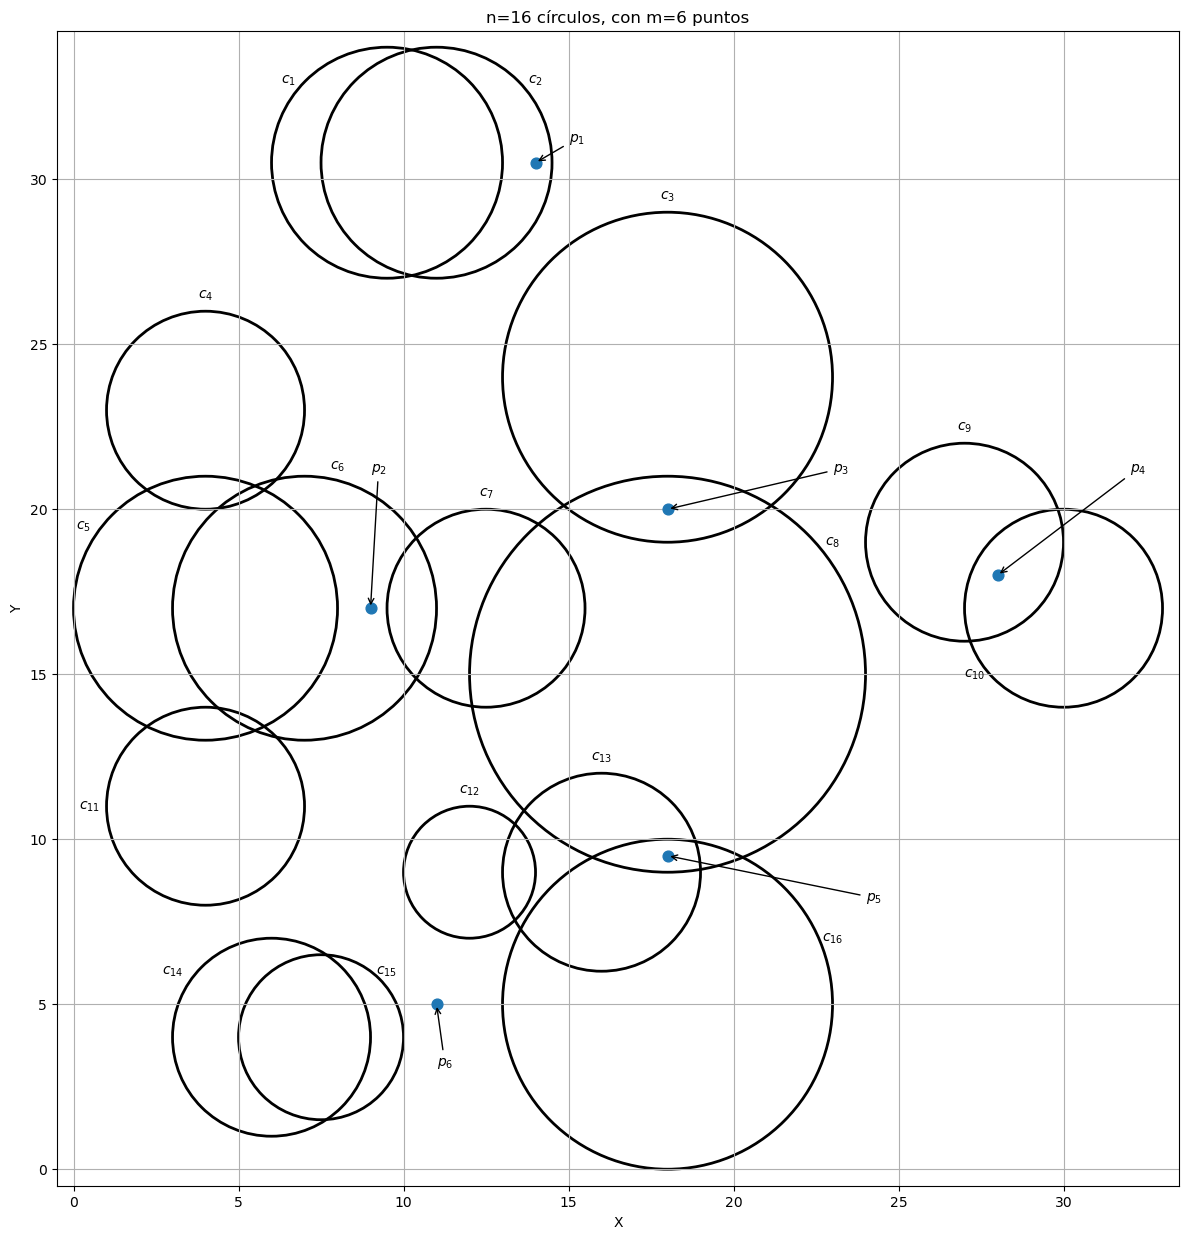

(<Figure size 1500x1500 with 1 Axes>,
 <Axes: title={'center': 'n=16 círculos, con m=6 puntos'}, xlabel='X', ylabel='Y'>)

In [187]:
annotations = [
    # {"anchor": "circle", "index": 9, "text": "Main cluster"},            # at circle center
    # {"anchor": "point",  "index": 1, "text": "Depot", "pos": (8.2, 17.8)},# offset with arrow
    {"anchor": "xy", "xy": (6.5, 33), "text": "$c_1$"},             # arbitrary location
    {"anchor": "xy", "xy": (14, 33), "text": "$c_2$"},             # arbitrary location
    {"anchor": "xy", "xy": (18, 29.5), "text": "$c_3$"},             # arbitrary location
    {"anchor": "xy", "xy": (4, 26.5), "text": "$c_4$"},             # arbitrary location
    {"anchor": "xy", "xy": (0.3, 19.5), "text": "$c_5$"},             # arbitrary location
    {"anchor": "xy", "xy": (8, 21.3), "text": "$c_6$"},             # arbitrary location
    {"anchor": "xy", "xy": (12.5, 20.5), "text": "$c_7$"},             # arbitrary location
    {"anchor": "xy", "xy": (23, 19), "text": "$c_8$"},             # arbitrary location
    {"anchor": "xy", "xy": (27, 22.5), "text": "$c_9$"},             # arbitrary location
    {"anchor": "xy", "xy": (27.3, 15), "text": "$c_{10}$"},             # arbitrary location
    {"anchor": "xy", "xy": (0.5, 11), "text": "$c_{11}$"},             # arbitrary location
    {"anchor": "xy", "xy": (12, 11.5), "text": "$c_{12}$"},             # arbitrary location
    {"anchor": "xy", "xy": (16, 12.5), "text": "$c_{13}$"},             # arbitrary location
    {"anchor": "xy", "xy": (3, 6), "text": "$c_{14}$"},             # arbitrary location
    {"anchor": "xy", "xy": (9.5, 6), "text": "$c_{15}$"},             # arbitrary location
    {"anchor": "xy", "xy": (23, 7), "text": "$c_{16}$"},             # arbitrary location

    {"anchor": "point",  "index": 1, "text": "$p_2$", "pos": (9, 21)},# offset with arrow
    {"anchor": "point",  "index": 2, "text": "$p_5$", "pos": (24, 8)},# offset with arrow
    {"anchor": "point",  "index": 3, "text": "$p_3$", "pos": (23, 21)},# offset with arrow
    {"anchor": "point",  "index": 4, "text": "$p_6$", "pos": (11, 3)},# offset with arrow
    {"anchor": "point",  "index": 5, "text": "$p_1$", "pos": (15, 31)},# offset with arrow
    {"anchor": "point",  "index": 0, "text": "$p_4$", "pos": (32, 21)},# offset with arrow
    # {"anchor": "circle", "index": 3, "text": "North hub","pos": (3.6, 18.6), "arrow": True, "style": {"fontsize": 9}}
]

plot_circles_points(
    circles=circles,
    points=points,
    annotations=annotations,
    show_vline=False,   # optional vertical line
    vline_x=1,
    title="n=16 círculos, con m=6 puntos"
)


Para la figura:

$C =\{c_1, c_2, c_3, c_4, c_5, c_6, c_7, c_8, c_9, c_{10}, c_{11}, c_{12}, c_{13}, c_{14}, c_{15}, c_{16} \}$

$P =\{p_1, p_2, p_3, p_4, p_5, p_6 \}$

## Observación 2.1
Un arreglo de *n* círculos divide al plano en un conjunto de regiones *R*, con máximo $O(n^2)$ regiones.


Para nuestro ejemplo $n=16$, por lo tanto $n^2=256$

Y hay 35 regiones

In [216]:
16**2

256

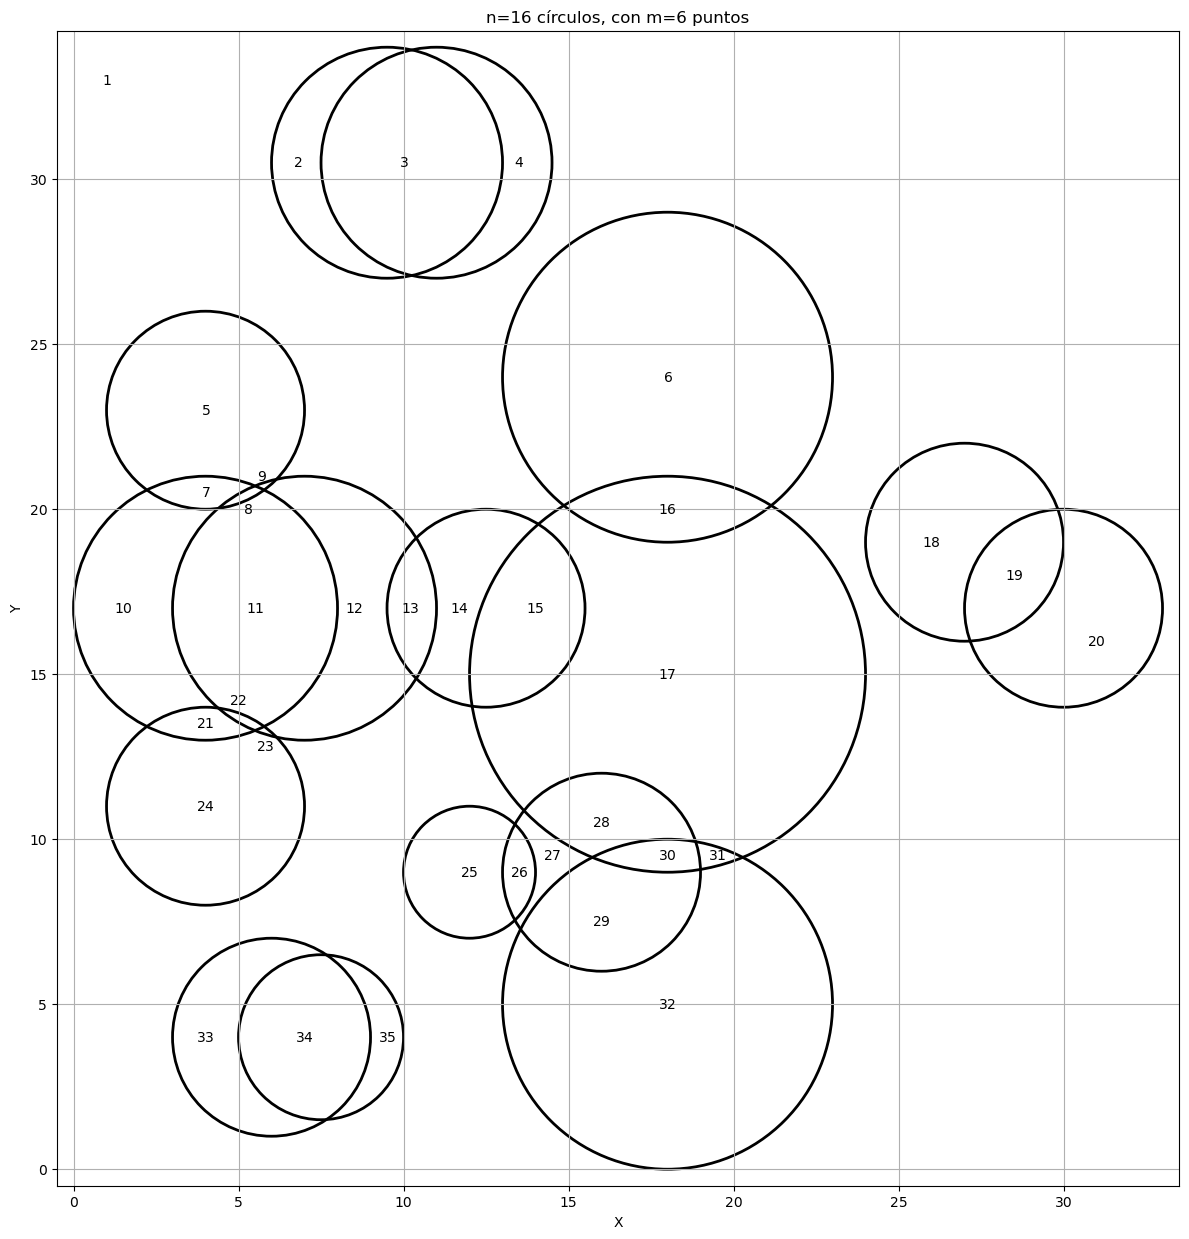

(<Figure size 1500x1500 with 1 Axes>,
 <Axes: title={'center': 'n=16 círculos, con m=6 puntos'}, xlabel='X', ylabel='Y'>)

In [260]:
annotations = [
    # {"anchor": "circle", "index": 9, "text": "Main cluster"},            # at circle center
    # {"anchor": "point",  "index": 1, "text": "Depot", "pos": (8.2, 17.8)},# offset with arrow
    {"anchor": "xy", "xy": (1, 33), "text": "$1$"},             # arbitrary location
    {"anchor": "xy", "xy": (6.8, 30.5), "text": "$2$"},             # arbitrary location
    {"anchor": "xy", "xy": (10, 30.5), "text": "$3$"},             # arbitrary location
    {"anchor": "xy", "xy": (13.5, 30.5), "text": "$4$"},             # arbitrary location
    {"anchor": "xy", "xy": (4, 23), "text": "$5$"},             # arbitrary location
    {"anchor": "xy", "xy": (18, 24), "text": "$6$"},             # arbitrary location
    {"anchor": "xy", "xy": (4, 20.5), "text": "$7$"},             # arbitrary location
    {"anchor": "xy", "xy": (5.3, 20), "text": "$8$"},             # arbitrary location
    {"anchor": "xy", "xy": (5.7, 21), "text": "$9$"},             # arbitrary location
    {"anchor": "xy", "xy": (1.5, 17), "text": "$10$"},             # arbitrary location
    {"anchor": "xy", "xy": (5.5, 17), "text": "$11$"},             # arbitrary location
    {"anchor": "xy", "xy": (8.5, 17), "text": "$12$"},             # arbitrary location
    {"anchor": "xy", "xy": (10.2, 17), "text": "$13$"},             # arbitrary location
    {"anchor": "xy", "xy": (11.7, 17), "text": "$14$"},             # arbitrary location
    {"anchor": "xy", "xy": (14, 17), "text": "$15$"},             # arbitrary location
    {"anchor": "xy", "xy": (18, 20), "text": "$16$"},             # arbitrary location
    {"anchor": "xy", "xy": (18, 15), "text": "$17$"},             # arbitrary location
    {"anchor": "xy", "xy": (26, 19), "text": "$18$"},             # arbitrary location
    {"anchor": "xy", "xy": (28.5, 18), "text": "$19$"},             # arbitrary location
    {"anchor": "xy", "xy": (31, 16), "text": "$20$"},             # arbitrary location
    {"anchor": "xy", "xy": (4, 13.5), "text": "$21$"},             # arbitrary location
    {"anchor": "xy", "xy": (5, 14.2), "text": "$22$"},             # arbitrary location
    {"anchor": "xy", "xy": (5.8, 12.8), "text": "$23$"},             # arbitrary location
    {"anchor": "xy", "xy": (4, 11), "text": "$24$"},             # arbitrary location
    {"anchor": "xy", "xy": (12, 9), "text": "$25$"},             # arbitrary location
    {"anchor": "xy", "xy": (13.5, 9), "text": "$26$"},             # arbitrary location
    {"anchor": "xy", "xy": (14.5, 9.5), "text": "$27$"},             # arbitrary location
    {"anchor": "xy", "xy": (16, 10.5), "text": "$28$"},             # arbitrary location
    {"anchor": "xy", "xy": (16, 7.5), "text": "$29$"},             # arbitrary location
    {"anchor": "xy", "xy": (18, 9.5), "text": "$30$"},             # arbitrary location
    {"anchor": "xy", "xy": (19.5, 9.5), "text": "$31$"},             # arbitrary location
    {"anchor": "xy", "xy": (18, 5), "text": "$32$"},             # arbitrary location
    {"anchor": "xy", "xy": (4, 4), "text": "$33$"},             # arbitrary location
    {"anchor": "xy", "xy": (7, 4), "text": "$34$"},             # arbitrary location
    {"anchor": "xy", "xy": (9.5, 4), "text": "$35$"},             # arbitrary location


    # {"anchor": "point",  "index": 1, "text": "$p_2$", "pos": (9, 21)},# offset with arrow
    # {"anchor": "point",  "index": 2, "text": "$p_5$", "pos": (24, 8)},# offset with arrow
    # {"anchor": "point",  "index": 3, "text": "$p_3$", "pos": (23, 21)},# offset with arrow
    # {"anchor": "point",  "index": 4, "text": "$p_6$", "pos": (11, 3)},# offset with arrow
    # {"anchor": "point",  "index": 5, "text": "$p_1$", "pos": (15, 31)},# offset with arrow
    # {"anchor": "point",  "index": 0, "text": "$p_4$", "pos": (32, 21)},# offset with arrow
    # {"anchor": "circle", "index": 3, "text": "North hub","pos": (3.6, 18.6), "arrow": True, "style": {"fontsize": 9}}
]

plot_circles_points(
    circles=circles,
    # points=points,
    annotations=annotations,
    show_vline=False,   # optional vertical line
    vline_x=1,
    title="n=16 círculos, con m=6 puntos"
)

### Observación 2.2

Si un círculo no está vacío, entonces es suficiente con encontrar un *testigo* (esto es, un punto dentro del círculo) para eliminarlo de la lista de círculos vacíos ("podarlo")

### Observación 2.3
Si un punto está en la región $r \in R$, entonces todos los círculos que contienen esta región no están vacíos, y pueden ser "podados".

## Algoritmo

### Definiciones

**Relación de orden parcial**

Para cada posición de la línea de barrido, definimos una **relación de orden parcial** $<_a$, en el conjunto de regiones $R$ de la siguiente forma:
Para dos regiones $r_i$ y $r_j$ en $R$, se dice que $r_i <_a r_j$ si la intersección de la región $r_i$ con la línea vertical $x=a$ cae debajo de la intersección de la región $r_j$ con la misma línea.

Este órden de información se mantiene en el *Estado de la Línea de barrido* denominado $\mathcal{L}$

**Punto de evento**

Un **punto de evento** puede ser el punto de interseción de dos círculos, o el punto más a la izquierda o más a la derecha de un círculo, o un punto de entrada.

**Orden de prioridad**

Los eventos se mantienen en una lista de prioridad $Q$, que al inicio del algoritmo contiene los puntos de entrada y los puntos más a la izquierda de cada círculo.

**Círculo activo**

A un círculo $C$ se le dice que está "activo" si está vacío o aún no se ha encontrado ningún testigo en él.

Al conjunto de círculos activos lo denotamos con $A_c$.

Inicialmente $A_c = C$

Para cada región $r$ llamamos $C_r$ al conjunto de círculos activos que contienen esa región.

# Ejemplo paso a paso

## Paso 1
* Círculos activos

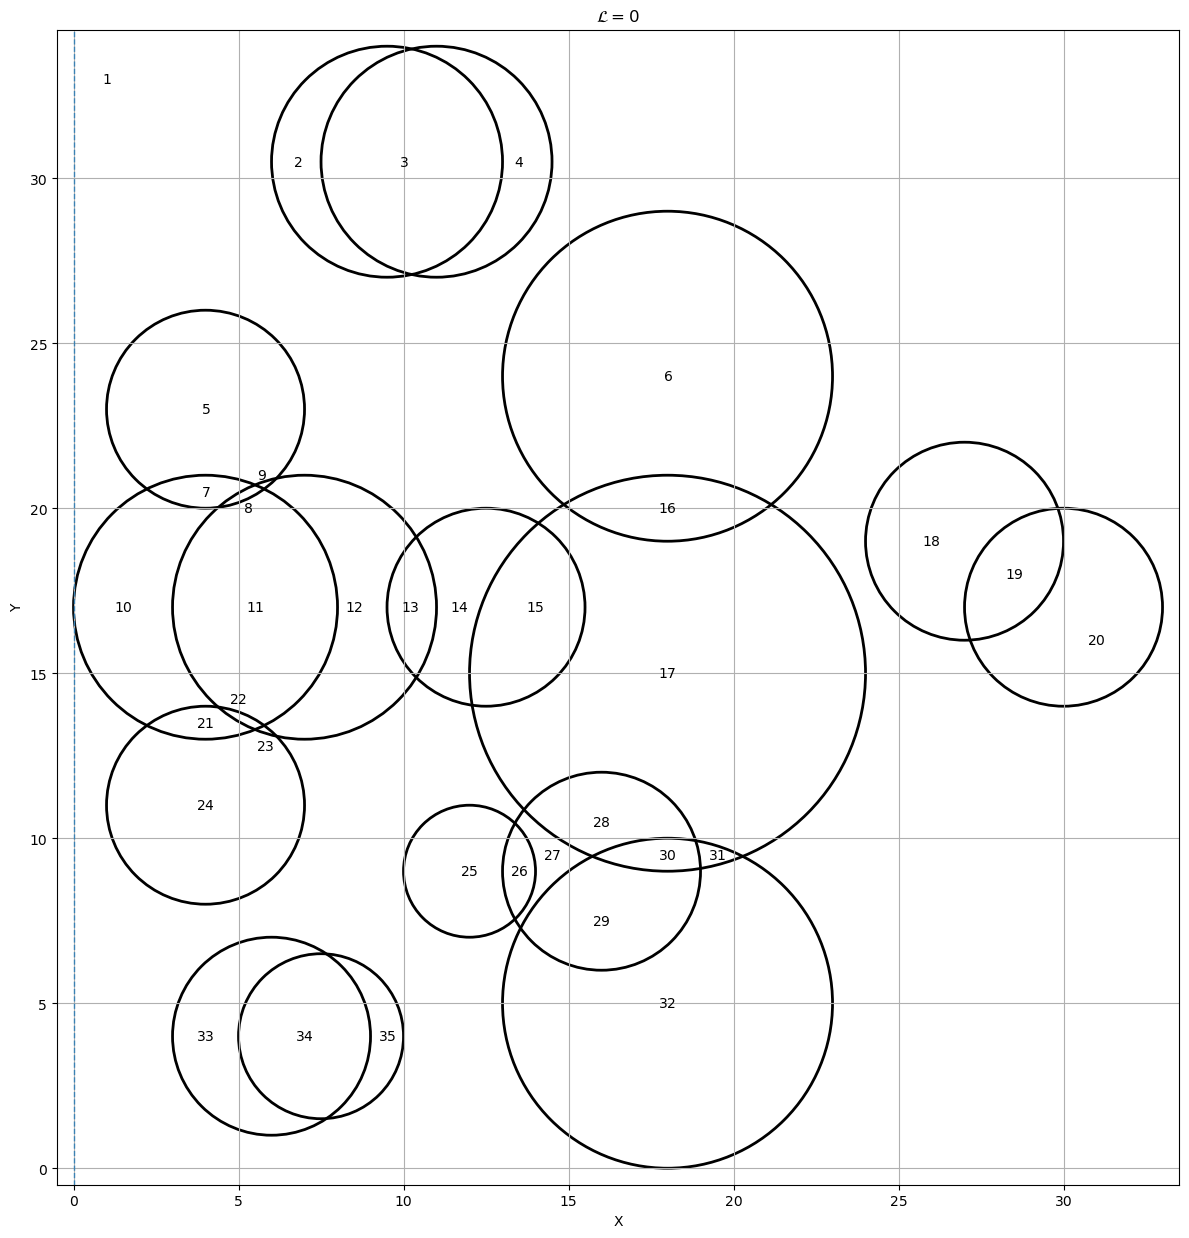

(<Figure size 1500x1500 with 1 Axes>,
 <Axes: title={'center': '$\\mathcal{L}=0$'}, xlabel='X', ylabel='Y'>)

In [262]:
annotations = [
    # {"anchor": "circle", "index": 9, "text": "Main cluster"},            # at circle center
    # {"anchor": "point",  "index": 1, "text": "Depot", "pos": (8.2, 17.8)},# offset with arrow
    {"anchor": "xy", "xy": (1, 33), "text": "$1$"},             # arbitrary location
    {"anchor": "xy", "xy": (6.8, 30.5), "text": "$2$"},             # arbitrary location
    {"anchor": "xy", "xy": (10, 30.5), "text": "$3$"},             # arbitrary location
    {"anchor": "xy", "xy": (13.5, 30.5), "text": "$4$"},             # arbitrary location
    {"anchor": "xy", "xy": (4, 23), "text": "$5$"},             # arbitrary location
    {"anchor": "xy", "xy": (18, 24), "text": "$6$"},             # arbitrary location
    {"anchor": "xy", "xy": (4, 20.5), "text": "$7$"},             # arbitrary location
    {"anchor": "xy", "xy": (5.3, 20), "text": "$8$"},             # arbitrary location
    {"anchor": "xy", "xy": (5.7, 21), "text": "$9$"},             # arbitrary location
    {"anchor": "xy", "xy": (1.5, 17), "text": "$10$"},             # arbitrary location
    {"anchor": "xy", "xy": (5.5, 17), "text": "$11$"},             # arbitrary location
    {"anchor": "xy", "xy": (8.5, 17), "text": "$12$"},             # arbitrary location
    {"anchor": "xy", "xy": (10.2, 17), "text": "$13$"},             # arbitrary location
    {"anchor": "xy", "xy": (11.7, 17), "text": "$14$"},             # arbitrary location
    {"anchor": "xy", "xy": (14, 17), "text": "$15$"},             # arbitrary location
    {"anchor": "xy", "xy": (18, 20), "text": "$16$"},             # arbitrary location
    {"anchor": "xy", "xy": (18, 15), "text": "$17$"},             # arbitrary location
    {"anchor": "xy", "xy": (26, 19), "text": "$18$"},             # arbitrary location
    {"anchor": "xy", "xy": (28.5, 18), "text": "$19$"},             # arbitrary location
    {"anchor": "xy", "xy": (31, 16), "text": "$20$"},             # arbitrary location
    {"anchor": "xy", "xy": (4, 13.5), "text": "$21$"},             # arbitrary location
    {"anchor": "xy", "xy": (5, 14.2), "text": "$22$"},             # arbitrary location
    {"anchor": "xy", "xy": (5.8, 12.8), "text": "$23$"},             # arbitrary location
    {"anchor": "xy", "xy": (4, 11), "text": "$24$"},             # arbitrary location
    {"anchor": "xy", "xy": (12, 9), "text": "$25$"},             # arbitrary location
    {"anchor": "xy", "xy": (13.5, 9), "text": "$26$"},             # arbitrary location
    {"anchor": "xy", "xy": (14.5, 9.5), "text": "$27$"},             # arbitrary location
    {"anchor": "xy", "xy": (16, 10.5), "text": "$28$"},             # arbitrary location
    {"anchor": "xy", "xy": (16, 7.5), "text": "$29$"},             # arbitrary location
    {"anchor": "xy", "xy": (18, 9.5), "text": "$30$"},             # arbitrary location
    {"anchor": "xy", "xy": (19.5, 9.5), "text": "$31$"},             # arbitrary location
    {"anchor": "xy", "xy": (18, 5), "text": "$32$"},             # arbitrary location
    {"anchor": "xy", "xy": (4, 4), "text": "$33$"},             # arbitrary location
    {"anchor": "xy", "xy": (7, 4), "text": "$34$"},             # arbitrary location
    {"anchor": "xy", "xy": (9.5, 4), "text": "$35$"},             # arbitrary location


    # {"anchor": "point",  "index": 1, "text": "$p_2$", "pos": (9, 21)},# offset with arrow
    # {"anchor": "point",  "index": 2, "text": "$p_5$", "pos": (24, 8)},# offset with arrow
    # {"anchor": "point",  "index": 3, "text": "$p_3$", "pos": (23, 21)},# offset with arrow
    # {"anchor": "point",  "index": 4, "text": "$p_6$", "pos": (11, 3)},# offset with arrow
    # {"anchor": "point",  "index": 5, "text": "$p_1$", "pos": (15, 31)},# offset with arrow
    # {"anchor": "point",  "index": 0, "text": "$p_4$", "pos": (32, 21)},# offset with arrow
    # {"anchor": "circle", "index": 3, "text": "North hub","pos": (3.6, 18.6), "arrow": True, "style": {"fontsize": 9}}
]

plot_circles_points(
    circles=circles,
    # points=points,
    annotations=annotations,
    show_vline=True,   # optional vertical line
    vline_x=0,
    title="$\mathcal{L}=0$"
)